# 第6章: 機械学習

In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip

Will not apply HSTS. The HSTS database must be a regular and non-world-writable file.
ERROR: could not open HSTS store at '/home/altair626/.wget-hsts'. HSTS will be disabled.
--2020-05-10 12:14:28--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  10.1MB/s    in 2.8s    

2020-05-10 12:14:32 (10.1 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]



In [2]:
!unzip NewsAggregatorDataset.zip

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [3]:
from stemming.porter2 import stem
import spacy
import re
from collections import Counter
from sklearn.linear_model import LogisticRegression
import pickle
import random
import numpy as np
import statistics
import matplotlib.pyplot as plt

## 50. データの入手・整形
News Aggregator Data Setをダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．

1. ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．
2. 情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．
3. 抽出された事例をランダムに並び替える．
4. 抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．

学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．



In [4]:
with open("./newsCorpora.csv", "r") as intxt:
    inline = intxt.readlines()
    
select_publisher = ["Reuters", "Huffington Post", "Businessweek", "Contactmusic.com", "Daily Mail"]
datas = []

for line in inline:
    if line != "":
        ll = line.split("\t")
        if ll[3] in select_publisher:
            datas.append((ll[4],ll[1]))

random.shuffle(datas)

In [5]:
print("all data :",len(datas))

with open("train.txt", "w") as out:
    for i in datas[:len(datas)*4//5]:
        print(i[0]+"\t"+i[1], file=out)
print("train data :",len(datas[:len(datas)*4//5]))

with open("valid.txt", "w") as out:
    for i in datas[len(datas)*8//10:len(datas)*9//10]:
        print(i[0]+"\t"+i[1], file=out)
print("valid data :",len(datas[len(datas)*8//10:len(datas)*9//10]))

with open("test.txt", "w") as out:
    for i in datas[len(datas)*9//10:]:
        print(i[0]+"\t"+i[1], file=out)
print("test data :",len(datas[len(datas)*9//10:]))

all data : 13356
train data : 10684
valid data : 1336
test data : 1336


In [6]:
!head train.txt

b	UPDATE 2-China June consumer inflation cools, more stimulus expected
e	Who Knew Sansa Stark Sophie Turner Could Sing?
e	Revealed: Shia LaBeouf 'was banned from L.A. restaurant for urinating on a wall  ...
b	Hong Kong Accountants Say Protests May Spur Exodus of Companies
b	Eurostar Passengers Face Delays After Power Supply Disruption
t	Drones, cyborgs and genetically altered babies: The potential future  ...
b	Former SAC, Och-Ziff Manager Said to Consider Own Hedge Fund (1)
b	Target 'respectfully' asks customers not to bring firearms to its stores after being  ...
b	UBS says books 254 million euros against second quarter to settle one German  ...
e	Former WWE Diva Stacy Keibler Marries In Secret Ceremony To Jared Pobre


## 51. 特徴量抽出
学習データ，検証データ，評価データから特徴量を抽出し，それぞれtrain.feature.txt，valid.feature.txt，test.feature.txtというファイル名で保存せよ． なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう．

In [7]:
nlp = spacy.load("en")

In [8]:
def get_data():
    test = []
    train = []
    valid = []
    with open("./test.txt") as intxt:
        line = intxt.readline()
        while line:
            test.append(tuple(line.strip("\n").split("\t")))
            line = intxt.readline()
    with open("./train.txt") as intxt:
        line = intxt.readline()
        while line:
            train.append(tuple(line.strip("\n").split("\t")))
            line = intxt.readline()
    with open("./valid.txt") as intxt:
        line = intxt.readline()
        while line:
            valid.append(tuple(line.strip("\n").split("\t")))
            line = intxt.readline()
    return train, test, valid

def get_feat_from_sentence(string):
    sl = nlp.make_doc(string)
    string = [stem(i.lemma_.lower()) for i in sl]
    return string

def data2stemmed(data):
    return [(label, get_feat_from_sentence(string)) for label,string in data]

def get_feature_stems(stemmed):
    counter = Counter([tok for _,toks in stemmed for tok in toks])
    #for i in counter.most_common():
    #    print(i)
    return [stem for stem,num in counter.most_common() if 2<num<1000]

def make_count_mat(stemmed, feature):
    tl = [label for label,_ in stemmed]
    xl = [make_count_vec(steml, feature) for _,steml in stemmed]
    return tl, xl

def make_count_vec(steml, feature):
    cd = Counter(steml)
    return [cd[stem] if stem in cd else 0 for stem in feature]

def write_features(filename, tl, xl, feature):
    assert len(tl)==len(xl)
    with open(filename, "w") as out:
        print(",".join(feature), file=out)
        for t,x in zip(tl,xl):
            print(t+","+",".join([str(int(i)) for i in x]), file=out)

In [9]:
train, test, valid = get_data()
train_stemmed = data2stemmed(train)
test_stemmed = data2stemmed(test)
valid_stemmed = data2stemmed(valid)

feature = get_feature_stems(train_stemmed)
train_t, train_x = make_count_mat(train_stemmed, feature)
test_t, test_x = make_count_mat(test_stemmed, feature)
valid_t, valid_x = make_count_mat(valid_stemmed, feature)

write_features("./train.feature.txt", train_t, train_x, feature)
write_features("./test.feature.txt", test_t, test_x, feature)
write_features("./valid.feature.txt", valid_t, valid_x, feature)

In [10]:
!head ./train.feature.txt -n 2

and,us,be,with,at,after,new,",$,say,stock,(,),up,from,not,is,by,?,kardashian,rise,it,;,over,china,will,share,her,euro,high,1,kim,fall,low,rate,-pron-,show,bank,star,deal,fed,may,!,about,year,2,day,market,dollar,out,sale,ecb,that,can,get,drop,see,buy,report,time,profit,billion,make,global,take,forex,gain,wall,off,you,near,miley,cyrus,but,datum,she,bond,cut,west,first,ceo,his,hit,reveal,do,record,set,plan,growth,week,top,much,price,bln,ukrain,video,open,st,kany,talk,as,pay,down,wed,month,end,game,more,million,no,chris,befor,justin,than,home,googl,this,film,he,bieber,one,gold,two,into,oil,inflat,3,2014,are,big,.,chang,how,go,job,your,back,all,appl,futur,car,american,who,call,man,movi,want,rais,die,ahead,outlook,face,against,what,tv,economi,york,case,world,just,correct,bid,war,fan,uk,look,&,court,drug,recal,rpt,trade,love,find,estim,offer,risk,loss,twitter,death,sinc,yellen,pct,﻿1,sell,ipo,forecast,expect,hold,america,beat,facebook,award,>,post,win,gm,help,quarter,studi,still,busi,claim,am

## 52. 学習
51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．

In [11]:
lr = LogisticRegression(max_iter=1000)
print(lr.fit(train_x, train_t))
print(lr.score(train_x, train_t))
print(lr.score(test_x, test_t))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
0.9879258704605017
0.8862275449101796


## 53. 予測
52で学習したロジスティック回帰モデルを用い，与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．

In [12]:
res = lr.predict_proba(test_x)
preds = res.argmax(axis=1)
probs = res.max(axis=1)
with open("53result.txt", "w") as out:
    for i in range(len(preds)):
        print(test_t[i], "->", res[i], preds[i], probs[i], file=out)

In [13]:
!head ./53result.txt

b -> [0.89576722 0.01367435 0.00914747 0.08141096] 0 0.8957672152757299
b -> [0.93174749 0.01080399 0.049394   0.00805452] 0 0.9317474938770007
b -> [9.99895991e-01 4.07583230e-05 5.43797901e-05 8.87058647e-06] 0 0.9998959913004706
t -> [3.34568921e-03 4.55783406e-04 7.09819606e-04 9.95488708e-01] 3 0.9954887077750038
e -> [0.30617824 0.47687529 0.05762052 0.15932595] 1 0.4768752918146913
e -> [1.02175533e-04 9.99729326e-01 1.32618276e-05 1.55236868e-04] 1 0.9997293257719784
b -> [9.93207977e-01 3.20887508e-03 1.45269793e-04 3.43787785e-03] 0 0.9932079772788674
m -> [0.94161226 0.02679419 0.00405353 0.02754002] 0 0.9416122550429745
m -> [0.61484684 0.11716507 0.24180123 0.02618686] 0 0.614846840007569
t -> [0.35651766 0.01655479 0.0604488  0.56647875] 3 0.5664787456857201


In [14]:
def predict_from_midashi(midashi, lr, feature):
    midashi_stemmed = get_feat_from_sentence(midashi)
    midashi_vec = make_count_vec(midashi_stemmed, feature)
    rc = lr.predict([midashi_vec])[0]
    res = lr.predict_proba([midashi_vec])[0]
    return rc,res,res.argmax(),res.max()

In [15]:
predict_from_midashi("Seconds away from disaster: Dramatic moment two planes almost collide on  ...", lr, feature) #testからとってきたもの、答えはb

('b',
 array([0.92851131, 0.05082671, 0.01028342, 0.01037857]),
 0,
 0.9285113064849492)

## 54. 正解率の計測
52で学習したロジスティック回帰モデルの正解率を，学習データおよび評価データ上で計測せよ．

In [16]:
def accuracy(lr, xl, tl):
    res = lr.predict(xl)
    return (res==tl).mean()

In [17]:
print("train :",accuracy(lr, train_x, train_t))
print("test : ",accuracy(lr, test_x, test_t))

train : 0.9879258704605017
test :  0.8862275449101796


## 55. 混同行列の作成
52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ．

In [18]:
def make_confusion_matrix(lr, xl, tl):
    label_dic = {"b":0, "e":1, "m":2, "t":3}
    mat = np.zeros((4,4),dtype=int)
    res = lr.predict(xl)
    for gold_label, system_label in zip(tl, res):
        mat[label_dic[system_label]][label_dic[gold_label]] += 1
    return mat

In [19]:
print(make_confusion_matrix(lr, train_x, train_t))
print(make_confusion_matrix(lr, test_x, test_t))

[[4483   12    9   43]
 [  11 4231    6   17]
 [   1    1  689    2]
 [  22    4    1 1152]]
[[523  19  14  38]
 [ 20 492  10  17]
 [  4   0  65   7]
 [ 13   8   2 104]]


## 56. 適合率，再現率，F1スコアの計測
52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．カテゴリごとに適合率，再現率，F1スコアを求め，カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．

In [20]:
def macro_score(mat):
    scores_part = [macro_score_part(mat, target) for target in range(4)]
    recall = statistics.mean([i[0] for i in scores_part])
    precision = statistics.mean([i[1] for i in scores_part])
    f1_score = 2*recall*precision / (recall+precision)
    return recall, precision, f1_score

def macro_score_part(mat, target):
    msum = np.sum(mat)
    TP = mat[target][target]
    FP = sum(mat[target]) - TP
    FN = sum(mat[:,target]) - TP
    TN = msum - TP - FP - FN
    recall = TP/(TP+FN)
    precision = TP/(TP+FP)
    return recall, precision, msum, TP, FP, FN, TN

def micro_score(mat):
    msum = np.sum(mat)
    TP = sum([mat[i][i] for i in range(4)])
    FP = msum - TP
    score = TP/(TP+FP)
    return score

def print_scores(mat):
    print(mat)
    scores = [micro_score(mat)] + list(macro_score(mat))
    print("macro_precision", scores[2])
    print("macro_recall", scores[1])
    print("macro_f1", scores[3])
    print("micro", scores[0])

In [21]:
mm = make_confusion_matrix(lr, train_x, train_t)
print_scores(mm)

mm = make_confusion_matrix(lr, test_x, test_t)
print_scores(mm)

[[4483   12    9   43]
 [  11 4231    6   17]
 [   1    1  689    2]
 [  22    4    1 1152]]
macro_precision 0.9873200381081855
macro_recall 0.9786762803330958
macro_f1 0.9829791575196268
micro 0.9879258704605017
[[523  19  14  38]
 [ 20 492  10  17]
 [  4   0  65   7]
 [ 13   8   2 104]]
macro_precision 0.8668584150978622
macro_recall 0.805674297105847
macro_f1 0.835147246063783
micro 0.8862275449101796


## 57. 特徴量の重みの確認
52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ．

In [22]:
category = {"b":"business", "e":"entertainment", "m":"health", "t":"science and technology"}

for i,label in enumerate(["b", "e", "m", "t"]):
    print(category[label])
    indexl = lr.coef_[i].argsort()
    for j,index in enumerate(indexl[:-11:-1]):
        print(j+1,feature[index],lr.coef_[i][index])
        
    for j,index in enumerate(indexl[:10]):
        print(j+1,feature[index],lr.coef_[i][index])
    print("############################")

business
1 fed 1.7837730552942508
2 bank 1.7078076159579358
3 ukrain 1.699949415319417
4 obamacar 1.6639316680030383
5 oil 1.6117242870023283
6 ecb 1.559929416816782
7 euro 1.5465783415422434
8 dimon 1.516726624845893
9 argentina 1.5042282136222527
10 yellen 1.478604804555159
1 activis -1.8809704421129143
2 aereo -1.2581859453799855
3 babi -1.1522870017923905
4 subscript -1.1184967213565717
5 virus -1.1083828751215674
6 ebola -1.0453484282092977
7 heart -1.0270961614262077
8 video -1.0259611559833435
9 victim -1.017232320755058
10 whale -1.0036464036969044
############################
entertainment
1 kardashian 1.7660846440006697
2 film 1.601259493069088
3 paul 1.5905894656708441
4 chris 1.527341065692933
5 wed 1.448162688744093
6 movi 1.4331000049566671
7 miley 1.3893636303756556
8 cyrus 1.3492782167780089
9 voic 1.3247638951491347
10 georg 1.3033430806902964
1 googl -1.3368428767044536
2 china -1.2538276691658574
3 scientist -1.1903585796343075
4 facebook -1.1544823961472792
5 fine -

## 58. 正則化パラメータの変更
ロジスティック回帰モデルを学習するとき，正則化パラメータを調整することで，学習時の過学習（overfitting）の度合いを制御できる．異なる正則化パラメータでロジスティック回帰モデルを学習し，学習データ，検証データ，および評価データ上の正解率を求めよ．実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ．

In [23]:
xaxis = [i/10 for i in range(1,51)]
#lrl = [LogisticRegression(C=c/10, max_iter=1000).fit(train_x, train_t) for c in xaxis]
lrl = []
for c in xaxis:
    lrl.append(LogisticRegression(C=c, max_iter=1000).fit(train_x, train_t))
    print(c)

train_accul = [accuracy(lr, train_x, train_t) for lr in lrl]
test_accul = [accuracy(lr, test_x, test_t) for lr in lrl]
valid_accul = [accuracy(lr, valid_x, valid_t) for lr in lrl]

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0


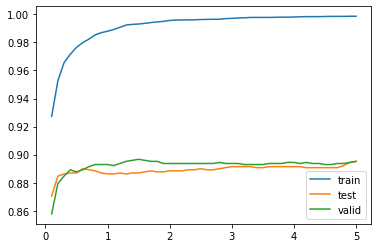

In [24]:
plt.plot(xaxis, train_accul, label="train")
plt.plot(xaxis, test_accul, label="test")
plt.plot(xaxis, valid_accul, label="valid")
plt.legend()
plt.show()

## 59. ハイパーパラメータの探索
学習アルゴリズムや学習パラメータを変えながら，カテゴリ分類モデルを学習せよ．検証データ上の正解率が最も高くなる学習アルゴリズム・パラメータを求めよ．また，その学習アルゴリズム・パラメータを用いたときの評価データ上の正解率を求めよ．

In [25]:
from sklearn import svm

In [26]:
clf = svm.LinearSVC(C=1.0)
clf.fit(train_x, train_t)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [27]:
print(accuracy(clf, train_x, train_t))
print(accuracy(clf, test_x, test_t))

0.9982216398352677
0.8944610778443114


In [28]:
xaxis = [i/10 for i in range(1,26)]
clfl = []
for c in xaxis:
    clfl.append(svm.LinearSVC(C=c, max_iter=1000).fit(train_x, train_t))
    print(c)

train_accul = [accuracy(clf, train_x, train_t) for clf in clfl]
test_accul = [accuracy(clf, test_x, test_t) for clf in clfl]
valid_accul = [accuracy(clf, valid_x, valid_t) for clf in clfl]

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5


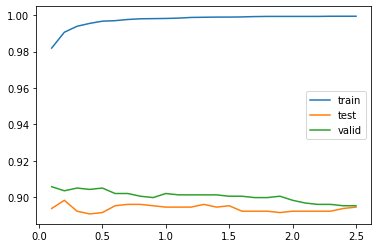

In [29]:
plt.plot(xaxis, train_accul, label="train")
plt.plot(xaxis, test_accul, label="test")
plt.plot(xaxis, valid_accul, label="valid")
plt.legend()
plt.show()

In [30]:
max(valid_accul)

0.905688622754491

0.0001
0.001
0.01
0.1
1


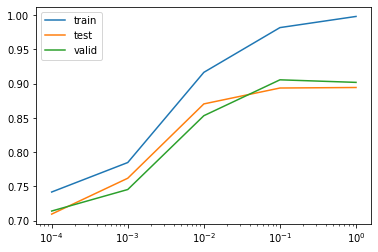

In [31]:
xaxis = [0.0001, 0.001, 0.01, 0.1, 1]
clfl = []
for c in xaxis:
    clfl.append(svm.LinearSVC(C=c, max_iter=1000).fit(train_x, train_t))
    print(c)

train_accul = [accuracy(clf, train_x, train_t) for clf in clfl]
test_accul = [accuracy(clf, test_x, test_t) for clf in clfl]
valid_accul = [accuracy(clf, valid_x, valid_t) for clf in clfl]

plt.plot(xaxis, train_accul, label="train")
plt.plot(xaxis, test_accul, label="test")
plt.plot(xaxis, valid_accul, label="valid")
plt.xscale('log')
plt.legend()
plt.show()

In [33]:
max(valid_accul)

0.905688622754491

In [34]:
from sklearn import naive_bayes

In [35]:
clf = naive_bayes.MultinomialNB()
clf.fit(train_x, train_t)
print(accuracy(clf, train_x, train_t))
print(accuracy(clf, test_x, test_t))

0.9389741669786597
0.8907185628742516


In [36]:
xaxis = [i/10 for i in range(1,26)]
clfl = []
for c in xaxis:
    clfl.append(naive_bayes.MultinomialNB(alpha=c).fit(train_x, train_t))
    print(c)

train_accul = [accuracy(clf, train_x, train_t) for clf in clfl]
test_accul = [accuracy(clf, test_x, test_t) for clf in clfl]
valid_accul = [accuracy(clf, valid_x, valid_t) for clf in clfl]

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5


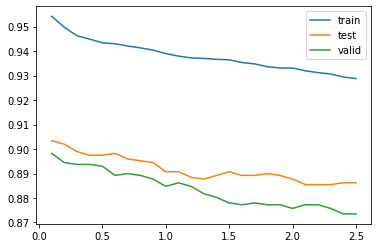

In [37]:
plt.plot(xaxis, train_accul, label="train")
plt.plot(xaxis, test_accul, label="test")
plt.plot(xaxis, valid_accul, label="valid")
plt.legend()
plt.show()

In [38]:
max(valid_accul)

0.8982035928143712

0.0001
0.001
0.01
0.1
1


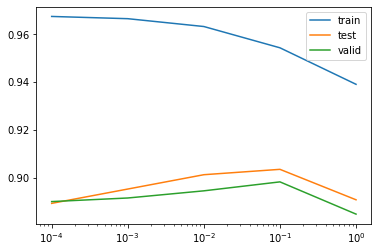

In [39]:
xaxis = [0.0001, 0.001, 0.01, 0.1, 1]
clfl = []
for c in xaxis:
    clfl.append(naive_bayes.MultinomialNB(alpha=c).fit(train_x, train_t))
    print(c)

train_accul = [accuracy(clf, train_x, train_t) for clf in clfl]
test_accul = [accuracy(clf, test_x, test_t) for clf in clfl]
valid_accul = [accuracy(clf, valid_x, valid_t) for clf in clfl]

plt.plot(xaxis, train_accul, label="train")
plt.plot(xaxis, test_accul, label="test")
plt.plot(xaxis, valid_accul, label="valid")
plt.xscale('log')
plt.legend()
plt.show()

In [40]:
max(valid_accul)

0.8982035928143712